# 主要两个思想
+ 马尔科夫假设：当前只与固定长度的序列相关
+ 潜变量：类rnn，潜变量存储了历史信息，随前一状态不断更新

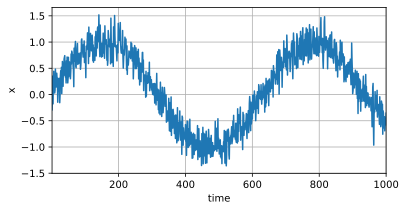

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))  # 高斯分布作为噪音
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))  # x,y,x_label,y_label

In [2]:
x

tensor([-0.2924,  0.0292,  0.3509, -0.1772,  0.2219,  0.4424,  0.1493,  0.1419,
         0.0287,  0.0802,  0.4842,  0.2896,  0.1416,  0.2688,  0.4055,  0.3046,
         0.3155, -0.1462,  0.1007,  0.3052,  0.0619,  0.2158,  0.3085, -0.1558,
        -0.0062,  0.3611,  0.4548,  0.2256,  0.5188,  0.0182,  0.2322,  0.6293,
         0.2298,  0.1576,  0.5997,  0.3642,  0.6771,  0.7132,  0.7408,  0.3869,
         0.3325,  0.3913,  0.2213,  0.6413,  0.2796,  0.7143,  0.5282,  0.2218,
         0.3196,  0.7088,  0.3380,  0.6171,  0.6220,  0.3674,  0.4356,  0.3016,
         0.4488,  0.7716,  0.5808,  0.8266,  0.8019,  0.6492,  0.7594,  0.5384,
         0.4720,  0.1500,  0.8834,  0.7039,  0.6332,  0.9181,  1.0113,  0.5324,
         0.5093,  0.8294,  0.6490,  0.8825,  0.9729,  0.5743,  0.6402,  0.7821,
         0.5920,  0.7224,  0.6913,  0.7691,  0.7933,  0.4817,  0.5508,  0.7255,
         1.0417,  1.0592,  0.8516,  0.9445,  0.7793,  0.7136,  0.9494,  0.8141,
         1.0202,  0.6092,  0.7956,  0.75

In [25]:
tau = 4
features = torch.zeros((T - tau, tau))  # 996*4
for i in range(tau):
    features[:, i] = x[i: T - tau + i]  # 对列
labels = x[tau:].reshape((-1, 1))  # 最后维度设置1，自动改前面
print((labels))
# 上面步骤完成后，996行都是一个样本
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
# 用于将数据集加载到内存中，并生成 DataLoader 对象以供模型进行训练和测试。
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)
features[:n_train].shape,labels[:n_train].shape

tensor([[ 0.2219],
        [ 0.4424],
        [ 0.1493],
        [ 0.1419],
        [ 0.0287],
        [ 0.0802],
        [ 0.4842],
        [ 0.2896],
        [ 0.1416],
        [ 0.2688],
        [ 0.4055],
        [ 0.3046],
        [ 0.3155],
        [-0.1462],
        [ 0.1007],
        [ 0.3052],
        [ 0.0619],
        [ 0.2158],
        [ 0.3085],
        [-0.1558],
        [-0.0062],
        [ 0.3611],
        [ 0.4548],
        [ 0.2256],
        [ 0.5188],
        [ 0.0182],
        [ 0.2322],
        [ 0.6293],
        [ 0.2298],
        [ 0.1576],
        [ 0.5997],
        [ 0.3642],
        [ 0.6771],
        [ 0.7132],
        [ 0.7408],
        [ 0.3869],
        [ 0.3325],
        [ 0.3913],
        [ 0.2213],
        [ 0.6413],
        [ 0.2796],
        [ 0.7143],
        [ 0.5282],
        [ 0.2218],
        [ 0.3196],
        [ 0.7088],
        [ 0.3380],
        [ 0.6171],
        [ 0.6220],
        [ 0.3674],
        [ 0.4356],
        [ 0.3016],
        [ 0.

(torch.Size([600, 4]), torch.Size([600, 1]))

In [4]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)  # 设置对那些参数进行优化
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.078191
epoch 2, loss: 0.061193
epoch 3, loss: 0.055719
epoch 4, loss: 0.052768
epoch 5, loss: 0.050117


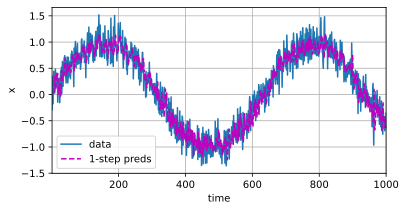

In [24]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

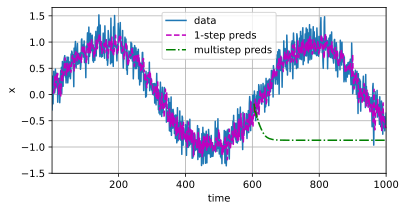

In [26]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

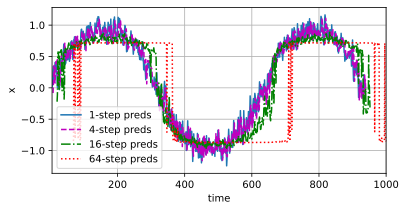

In [27]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))